(plot_museum)=
# PlotMuseum overview
This notebook builds on top of {ref}`data_organizers` to show usage of `PlotMuseum` class.

In [1]:
import arviz as az
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
xr.set_options(display_expand_data=False);
az.style.use("arviz-white")

In [3]:
idata = az.load_arviz_data("rugby")
post = idata.posterior

In [4]:
from xrtist import PlotMuseum

`PlotMuseum` is an attempt to generalize the existing features of `PlotCollection` to take `Dataset` inputs.
Thus, the `.viz` and `.dt` (previously `.ds`) are now DataTree objects.

Again, we define our kde_artist to get started:

In [5]:
def kde_artist(values, target, **kwargs):
    kwargs.pop("backend")
    grid, pdf = az.kde(np.array(values).flatten())
    return target.plot(grid, pdf, **kwargs)[0]

### Base example: plot kdes for each of the 6 teams
We start with a basic example, plotting a kde for each of the teams. In this case, we only want to generate a subplot for each team, no aesthetics or anything else. We indicate this with `col=["team"]`.

Note however that we now have two variables because the input is a Dataset, therefore, even though we provide no aesthetics, as we plot multiple lines
in the same plot, matplotlib uses the default prop_cycle to distinguish the lines

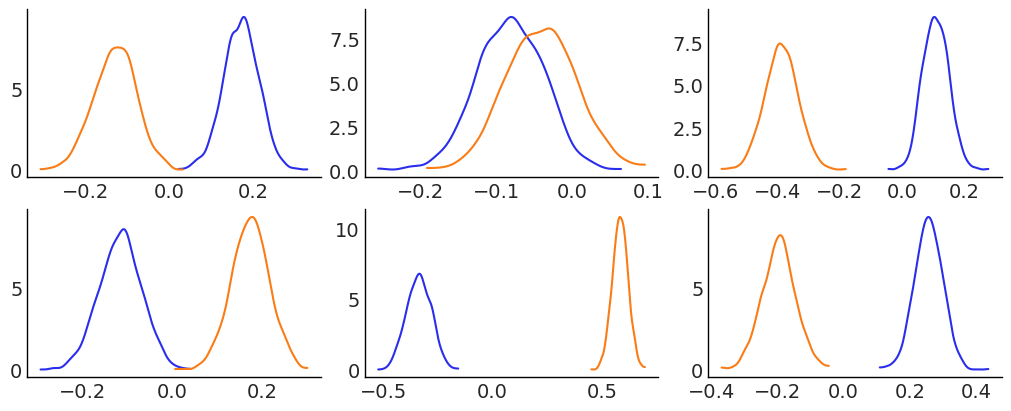

In [6]:
pc = PlotMuseum.wrap(
    post[["atts", "defs"]], 
    cols=["team"],
    col_wrap=3,
    plot_grid_kws={"figsize": (10, 4)}
)
pc.map(kde_artist, "kde")

### 2d grid example

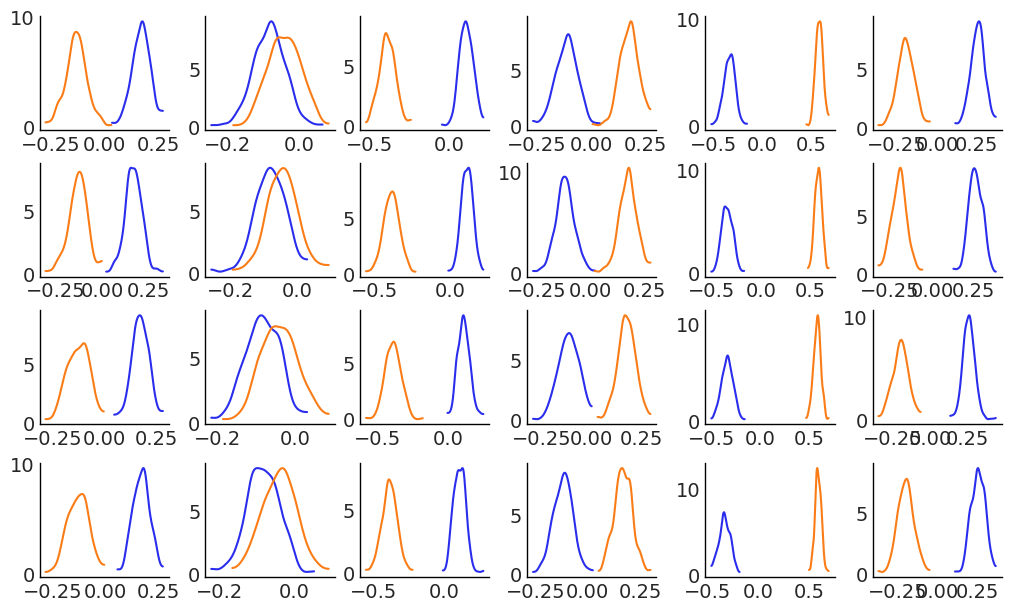

In [7]:
pc = PlotMuseum.grid(
    post[["atts", "defs"]], 
    cols=["team"],
    rows=["chain"], 
    plot_grid_kws={"figsize": (10, 6)}
)
pc.map(kde_artist, "kde")

### Introduce "__variable__"
We can now use `"__variable__"` string instead of a dimension name to indicate we don't want to overlay variables but to facet on them.

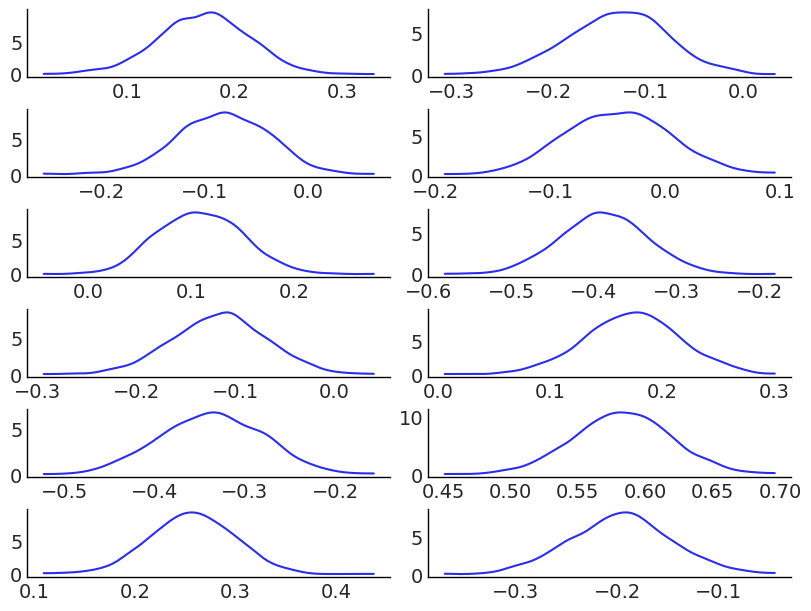

In [8]:
pc = PlotMuseum.grid(
    post[["atts", "defs"]], 
    cols=["__variable__"],
    rows=["team"], 
    plot_grid_kws={"figsize": (8, 6)}
)
pc.map(kde_artist, "kde")

It can be combined with dimensions in order to get the default "concat" style we use in ArviZ:

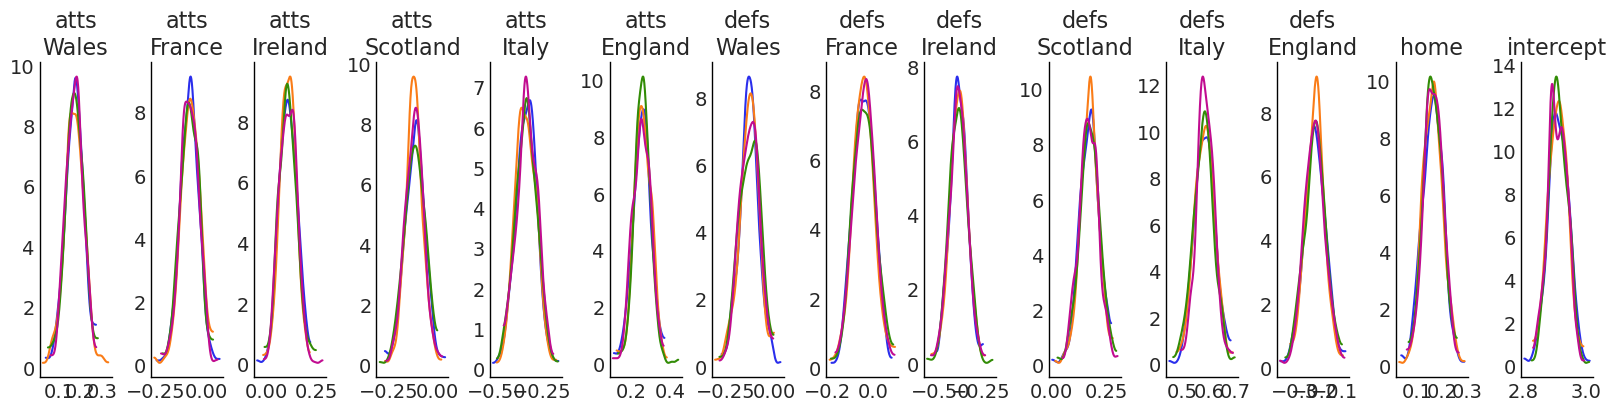

In [9]:
def title_artist(values, target, var_name, sel, isel, labeller_fun, **kwargs):
    kwargs.pop("backend")
    label = labeller_fun(var_name, sel, isel)
    return target.set_title(label, **kwargs)  

pc = PlotMuseum.grid(
    post[["atts", "defs", "home", "intercept"]], 
    cols=["__variable__", "team"],
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    plot_grid_kws={"figsize": (16, 4)},
)
pc.map(kde_artist, "kde")
# add title to help visualize what is happening
pc.map(title_artist, "title", subset_info=True, labeller_fun=az.labels.BaseLabeller().make_label_vert, ignore_aes={"color"})

In [10]:
pc.viz

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       chart    object Figure(1600x400)
├── DataTree('atts')
│       Dimensions:  (team: 6, chain: 4)
│       Coordinates:
│         * team     (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
│         * chain    (chain) int64 0 1 2 3
│       Data variables:
│           plot     (team) object AxesSubplot(0.0211113,0.0700703;0.0449375x0.787179...
│           row      (team) int64 0 0 0 0 0 0
│           col      (team) int64 0 1 2 3 4 5
│           kde      (chain, team) object Line2D(_child0) ... Line2D(_child3)
│           title    (team) object Text(0.5, 1.0, 'atts\nWales') ... Text(0.5, 1.0, '...
├── DataTree('defs')
│       Dimensions:  (team: 6, chain: 4)
│       Coordinates:
│         * team     (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
│         * chain    (chain) int64 0 1 2 3
│       Data variables:
│           plot     (team) object AxesSubplot(0.441239,0.0700703;0.0449375x0.787179)...
│           row      (team) int64 0 0 0 0 0 0
│           col      (team) int64 6 7 8 9 10 11
│           kde      (chain, team) object Line2D(_child0) ... Line2D(_child3)
│           title    (team) object Text(0.5, 1.0, 'defs\nWales') ... Text(0.5, 1.0, '...
├── DataTree('home')
│       Dimensions:  (chain: 4)
│       Coordinates:
│         * chain    (chain) int64 0 1 2 3
│       Data variables:
│           plot     object AxesSubplot(0.868812,0.0700703;0.0449375x0.787179)
│           row      int64 0
│           col      int64 12
│           kde      (chain) object Line2D(_child0) Line2D(_child1) ... Line2D(_child3)
│           title    object Text(0.5, 1.0, 'home')
└── DataTree('intercept')
        Dimensions:  (chain: 4)
        Coordinates:
          * chain    (chain) int64 0 1 2 3
        Data variables:
            plot     object AxesSubplot(0.947029,0.0700703;0.0449375x0.787179)
            row      int64 0
            col      int64 13
            kde      (chain) object Line2D(_child0) Line2D(_child1) ... Line2D(_child3)
            title    object Text(0.5, 1.0, 'intercept')

Or paired with other other facettings and aesthetics:

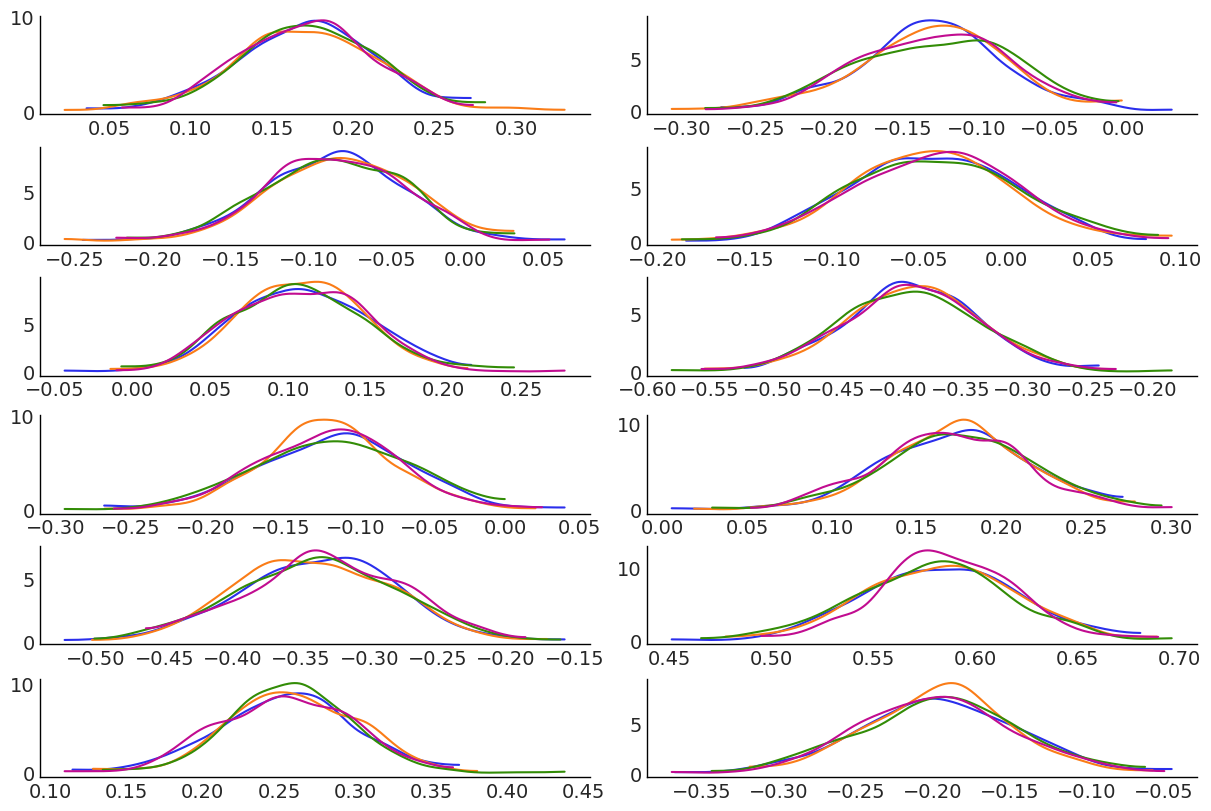

In [11]:
pc = PlotMuseum.grid(
    post[["atts", "defs"]], 
    cols=["__variable__"],
    rows=["team"], 
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    plot_grid_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")

### Multiple aesthetics for the same dimension

We can set multiple asethetics to the same dimension, and both will be updated in sync in all plots:

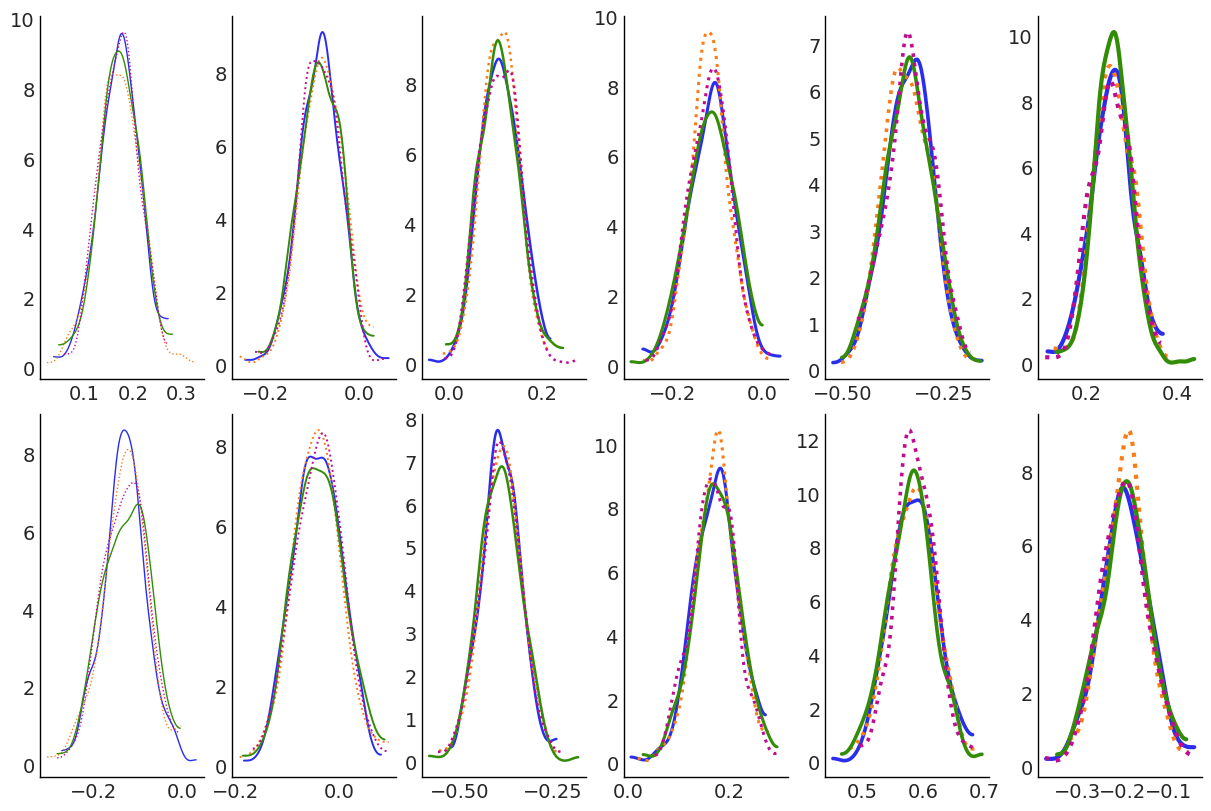

In [12]:
pc = PlotMuseum.grid(
    post[["atts", "defs"]], 
    cols=["team"], 
    rows=["__variable__"],
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    plot_grid_kws={"figsize": (12, 8)}
)
pc.map(kde_artist)

### Easy access to all plots elements

And as we have stored all the plotting related data, including artists in the `.viz` attribute, we can select artists from the plot and modify them _with label based indexing_. Here we can make the line for `defs` of the Italy team and 3rd chain have diamonds as markers after plotting, with size 10 and show markers only once every 50 datapoints.

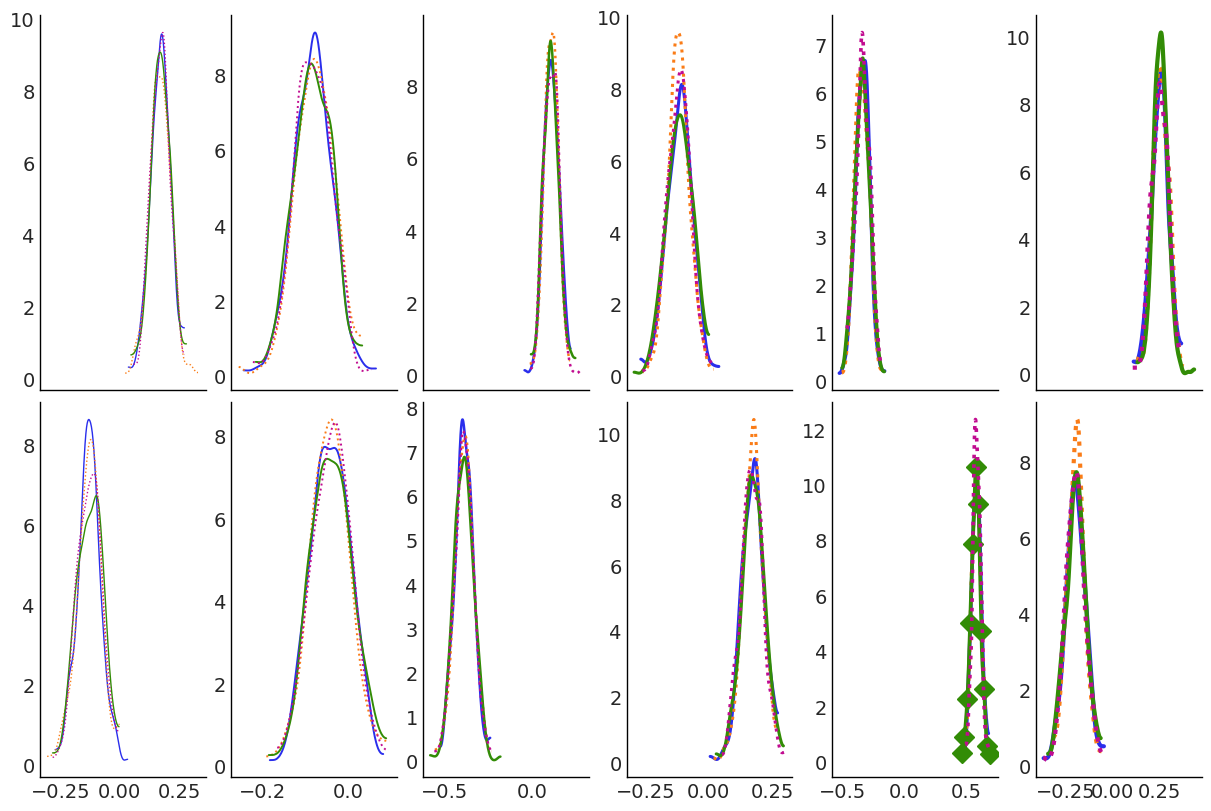

In [13]:
pc = PlotMuseum.grid(
    post[["atts", "defs"]], 
    cols=["team"], 
    rows=["__variable__"],
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    plot_grid_kws={"figsize": (12, 8), "sharex": "col"}  # share axis!
)
pc.map(kde_artist, "kde")
pc.viz["defs"]["kde"].sel(team="Italy", chain=2).item().set(marker="D", markersize=10, markevery=50);

## Mimic existing ArviZ functions
### plot_posterior
We will now mimic `plot_posterior`. We use functions from the visual module, which generate artists like we did for kde function. We add a couple extras here which are more aesthetic, so they are hidden to not interfere with reading.

In [14]:
def remove_left_axis(values, target, **kwargs):
    kwargs.pop("backend")
    target.get_yaxis().set_visible(False)
    target.spines['left'].set_visible(False)

We now mimic plot_posterior (dataarray input only). Plot posterior takes an inferencedata and automatically generates the axes and plots everything. With `PlotMuseum` this now becomes instatiating the class with some defaults (unless one is provided) and then calling `.map` multiple times to add all the elements to the plot: kde, hdi interval line, point estimate marker, point estimate text...

In [15]:
from xrtist import visuals

def plot_posterior(ds, plot_museum=None, labeller=None):
    if plot_museum is None:
        plot_museum = PlotMuseum.wrap(ds, cols=["__variable__"]+[dim for dim in ds.dims if dim not in {"chain", "draw"}], col_wrap=6, plot_grid_kws={"figsize": (8, 4)})
    if labeller is None:
        labeller = az.labels.BaseLabeller()
        
    labeller_fun = labeller.make_label_vert
    
    plot_museum.map(visuals.kde, "kde")
    plot_museum.map(visuals.interval, "interval", color="grey")    
    plot_museum.map(visuals.point, "point_estimate", color="C0", size=25, marker="o")
    plot_museum.map(visuals.point_label, "point_label", color="C0", va="bottom", ha="center")
    plot_museum.map(remove_left_axis, store_artist=False)
    plot_museum.map(title_artist, "title", subset_info=True, labeller_fun=labeller_fun)
    return plot_museum

Here it can be seen how the usage is the same basically as our current API, but if we also expose the artist function, it will be much easier for users to create their own variations of `plot_posterior` or to extend it with their own artist functions.

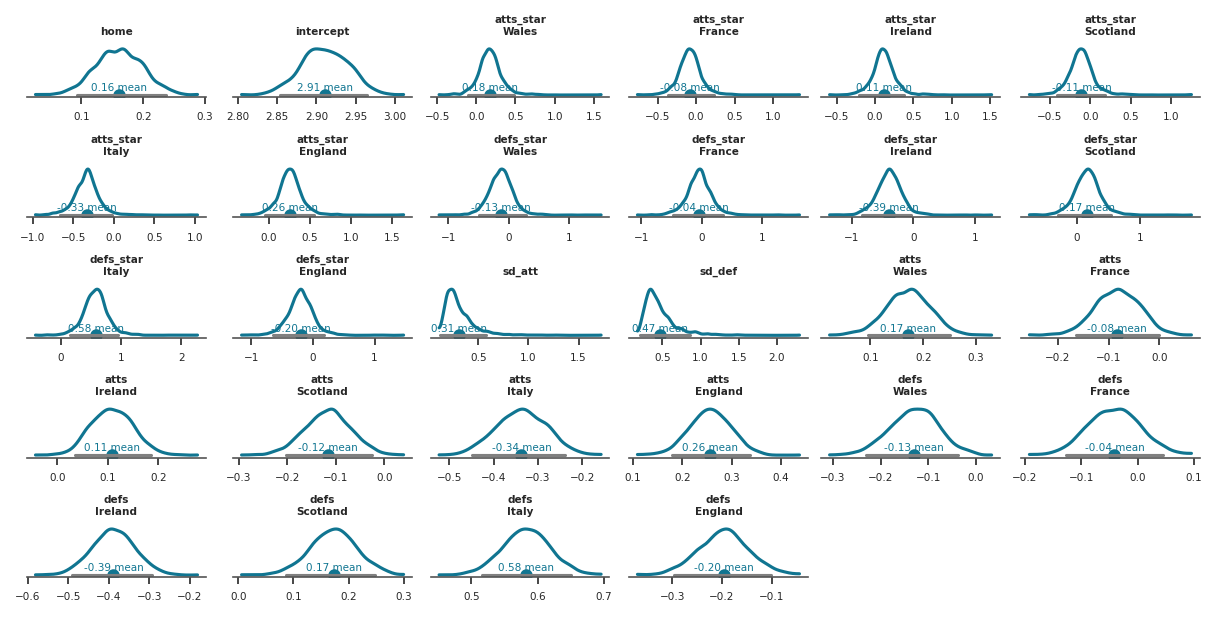

In [16]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

az.style.use("arviz-doc")
mpl.rcParams["figure.dpi"] = 150
for param in ("figure.titlesize", "axes.titlesize", "axes.labelsize", "xtick.labelsize", "ytick.labelsize", "font.size"):
    mpl.rcParams[param] = 5


pc = plot_posterior(post)
plt.show()

Finally, we show how all the elements added to the plot have had their corresponding artists added to the `.viz` dataset.

In [17]:
pc.viz

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       chart    object Figure(1200x600)
├── DataTree('home')
│       Dimensions:         ()
│       Data variables:
│           plot            object AxesSubplot(0.0155253,0.851567;0.148529x0.0845157)
│           row             int64 0
│           col             int64 0
│           kde             object Line2D(_child0)
│           interval        object Line2D(_child1)
│           point_estimate  object <matplotlib.collections.PathCollection object at 0...
│           point_label     object Text(0.16104307132482987, 0.5048045104779637, '0.1...
│           title           object Text(0.5, 1.0, 'home')
├── DataTree('intercept')
│       Dimensions:         ()
│       Data variables:
│           plot            object AxesSubplot(0.187258,0.851567;0.148529x0.0845157)
│           row             int64 0
│           col             int64 1
│           kde             object Line2D(_child0)
│           interval        object Line2D(_child1)
│           point_estimate  object <matplotlib.collections.PathCollection object at 0...
│           point_label     object Text(2.9108088389858, 0.6111895299650119, '2.91 me...
│           title           object Text(0.5, 1.0, 'intercept')
├── DataTree('atts_star')
│       Dimensions:         (team: 6)
│       Coordinates:
│         * team            (team) object 'Wales' 'France' ... 'Italy' 'England'
│       Data variables:
│           plot            (team) object AxesSubplot(0.351864,0.851567;0.148529x0.08...
│           row             (team) int64 0 0 0 0 1 1
│           col             (team) int64 2 3 4 5 0 1
│           kde             (team) object Line2D(_child0) ... Line2D(_child0)
│           interval        (team) object Line2D(_child1) ... Line2D(_child1)
│           point_estimate  (team) object <matplotlib.collections.PathCollection obje...
│           point_label     (team) object Text(0.17704792134457994, 0.157337803952773...
│           title           (team) object Text(0.5, 1.0, 'atts_star\nWales') ... Text...
├── DataTree('defs_star')
│       Dimensions:         (team: 6)
│       Coordinates:
│         * team            (team) object 'Wales' 'France' ... 'Italy' 'England'
│       Data variables:
│           plot            (team) object AxesSubplot(0.351864,0.651301;0.148529x0.08...
│           row             (team) int64 1 1 1 1 2 2
│           col             (team) int64 2 3 4 5 0 1
│           kde             (team) object Line2D(_child0) ... Line2D(_child0)
│           interval        (team) object Line2D(_child1) ... Line2D(_child1)
│           point_estimate  (team) object <matplotlib.collections.PathCollection obje...
│           point_label     (team) object Text(-0.13068105763613164, 0.10922850564475...
│           title           (team) object Text(0.5, 1.0, 'defs_star\nWales') ... Text...
├── DataTree('sd_att')
│       Dimensions:         ()
│       Data variables:
│           plot            object AxesSubplot(0.351864,0.451036;0.148529x0.0845157)
│           row             int64 2
│           col             int64 2
│           kde             object Line2D(_child0)
│           interval        object Line2D(_child1)
│           point_estimate  object <matplotlib.collections.PathCollection object at 0...
│           point_label     object Text(0.3117787219603789, 0.21112150824436948, '0.3...
│           title           object Text(0.5, 1.0, 'sd_att')
├── DataTree('sd_def')
│       Dimensions:         ()
│       Data variables:
│           plot            object AxesSubplot(0.517166,0.451036;0.148529x0.0845157)
│           row             int64 2
│           col             int64 3
│           kde             object Line2D(_child0)
│           interval        object Line2D(_child1)
│           point_estimate  object <matplotlib.collections.PathCollection object at 0...
│           point_label     object Text(0.46734608501396, 0.15429583566017946, '0.47 ...
│           title           ob

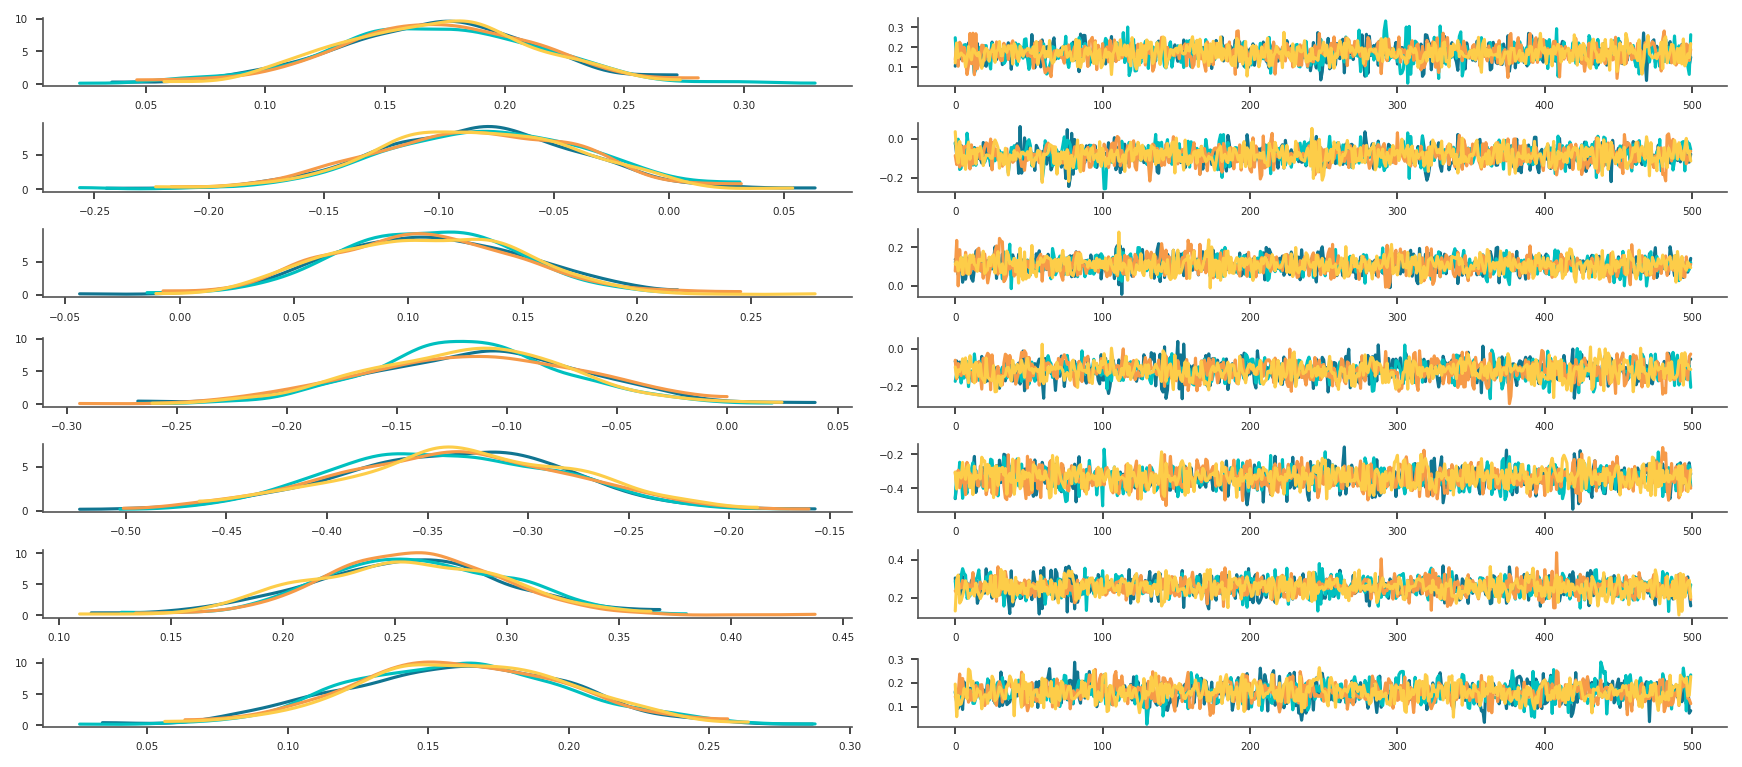

In [18]:
pc = PlotMuseum.grid(
    post[["atts", "home"]].expand_dims(column=2), # add dummy dim for the extra 2 col facetting
    rows=["__variable__", "team"],
    cols=["column"],
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
# plot on right column
pc.map(
    lambda values, target, backend, **kwargs: target.plot(
        np.arange(len(values)), values, **kwargs
    )[0],
    "trace",
    coords={"column": 1},
)
pc.map(kde_artist, "kde", coords={"column": 0})
plt.show()

In [19]:
pc.viz

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       chart    object Figure(1725x750)
├── DataTree('atts')
│       Dimensions:  (team: 6, column: 2, chain: 4)
│       Coordinates:
│         * team     (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
│         * chain    (chain) int64 0 1 2 3
│       Dimensions without coordinates: column
│       Data variables:
│           plot     (team, column) object AxesSubplot(0.0197587,0.895912;0.469004x0....
│           row      (team, column) int64 0 0 1 1 2 2 3 3 4 4 5 5
│           col      (team, column) int64 0 1 0 1 0 1 0 1 0 1 0 1
│           trace    (chain, team) object Line2D(_child0) ... Line2D(_child3)
│           kde      (chain, team) object Line2D(_child0) ... Line2D(_child3)
└── DataTree('home')
        Dimensions:  (column: 2, chain: 4)
        Coordinates:
          * chain    (chain) int64 0 1 2 3
        Dimensions without coordinates: column
        Data variables:
            plot     (column) object AxesSubplot(0.0197587,0.0411118;0.469004x0.09131...
            row      (column) int64 6 6
            col      (column) int64 0 1
            trace    (chain) object Line2D(_child0) Line2D(_child1) ... Line2D(_child3)
            kde      (chain) object Line2D(_child0) Line2D(_child1) ... Line2D(_child3)

more to come...